# Восстановление золота из руды


Цель: модель должна предсказать коэффициент восстановления золота из золотосодержащей руды 

# Содержание

1. Подготовка данных
 - 1.1 Импорт и общее изучение данных
 - 1.2 Расчёт эффективности обогащения руды
 - 1.3 Предобработка данных
2. Анализ данных
 - 2.1 Анализ концентрации металлов на разных этапах очистки
 - 2.2 Сравнение распределения размеров гранул сырья
 - 2.3 Исследование суммарной концентрации всех веществ на разных стадиях
3. Модель
 - 3.1 Функция расчёта отклонения
 - 3.2 Подготовка данных для обучения модели
 - 3.3 Обучаем модели
    - 3.3.1 Решающее дерево
    - 3.3.2 Случайный лес
    - 3.3.3 Линейная регрессия
    - 3.3.4 CatBoostRegressor
    - 3.3.4 Lasso
    - 3.3.5 Проверка на dummy модели 
 - 3.4 Проверка модели на тестовой выборке   

 
Решаем задачу регрессии с помощью машинного обучения с учителем

## Подготовка данных

### Импорт и общее изучение данных

Импортируем необходимые библиотеки, откроем файлы, обозначив индексом дату, и изучим их

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor

In [ ]:
data_train = pd.read_csv('/datasets/gold_recovery_train_new.csv', index_col='date')
data_test = pd.read_csv('/datasets/gold_recovery_test_new.csv', index_col='date')
data_full = pd.read_csv('/datasets/gold_recovery_full_new.csv', index_col='date')

In [ ]:
data_train.head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [ ]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14148 non-null  float64
 1   final.output.concentrate_pb                         14148 non-null  float64
 2   final.output.concentrate_sol                        13938 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14049 non-null  float64
 7   final.output.tail_sol                               14144 non-null  float64
 8   final.output.tail_au                             

In [ ]:
data_test.head()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,-500.810606,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [ ]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5286 non-null   float64
 1   primary_cleaner.input.depressant            5285 non-null   float64
 2   primary_cleaner.input.feed_size             5290 non-null   float64
 3   primary_cleaner.input.xanthate              5286 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5290 non-null

In [ ]:
data_full.head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [ ]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         19438 non-null  float64
 1   final.output.concentrate_pb                         19438 non-null  float64
 2   final.output.concentrate_sol                        19228 non-null  float64
 3   final.output.concentrate_au                         19439 non-null  float64
 4   final.output.recovery                               19439 non-null  float64
 5   final.output.tail_ag                                19438 non-null  float64
 6   final.output.tail_pb                                19338 non-null  float64
 7   final.output.tail_sol                               19433 non-null  float64
 8   final.output.tail_au                             

### Расчёт эффективности обогащения руды

Проверим, верно ли рассчитана эффективность обогащения. Для этого напишем функцию с формулой расчёта и применим её к обучающей выборке

In [ ]:
def enrichment_efficiency(C, F, T):
    recovery = []
    for i in range(len(C)):
        recovery.append(((C[i] * (F[i] - T[i])) / (F[i] * (C[i] - T[i]))) * 100)
    return recovery

In [ ]:
C = data_train['rougher.output.concentrate_au']
F = data_train['rougher.input.feed_au']
T = data_train['rougher.output.tail_au']

train_au_recovery = enrichment_efficiency(C, F, T)
mae = mean_absolute_error(data_train['rougher.output.recovery'], train_au_recovery)
print(mae)

9.73512347450521e-15


Как видим, значение среднего абсолютного отклонения стремится к нулю, а значит эффективность обогащения рассчитана верно

### Предобработка данных

Начнём предобработку с удаления строк, в которых нулевая концентрация металлов равна нулю. Если такие строки имеют место, значит это сбои работы фиксирующих датчиков, так как нулевой концентрации в данном случае быть не может. Также их наличие повредит на точность предсказаний нашей будущей модели

In [ ]:
phases = ['rougher.output.concentrate_au', 'rougher.output.concentrate_ag',
          'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol', 
         'rougher.input.feed_ag', 'rougher.input.feed_sol', 'rougher.input.feed_pb', 'rougher.input.feed_au',
         'final.output.concentrate_ag', 'final.output.concentrate_sol', 'final.output.concentrate_pb',
          'final.output.concentrate_au', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_ag', 
         'primary_cleaner.output.concentrate_au']
for phase in phases:
    data_train = data_train.loc[data_train[phase] != 0]

Сравнивая обучающую и тестовую выборки, мы видим, что в тестовой выборке отсутствуют некоторые признаки. Это финальные характеристики концентрата, а также выходные характеристики продукта на каждом этапе: флотация, первичная очистка, вторичная очистка. Не считая самих целевых признаков, которые мы добавим в тестовую часть позже, это необходимо для того, чтобы в обученной модели не произошла утечка целевого признака на тестовой выборке, так как выходные данные непосредственно влияют на его определение

Удалим пропуски в обучающих данных, так как достоверно их восстановить не получится, а обратное ещё хуже отразится на качестве модели

In [ ]:
data_train = data_train.dropna()
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10737 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         10737 non-null  float64
 1   final.output.concentrate_pb                         10737 non-null  float64
 2   final.output.concentrate_sol                        10737 non-null  float64
 3   final.output.concentrate_au                         10737 non-null  float64
 4   final.output.recovery                               10737 non-null  float64
 5   final.output.tail_ag                                10737 non-null  float64
 6   final.output.tail_pb                                10737 non-null  float64
 7   final.output.tail_sol                               10737 non-null  float64
 8   final.output.tail_au                             

Проведя расчёты и предобработку данных, мы обнаружили, что некоторые значения эффективности обогащения могли быть рассчитаны некорректно. В данных были обнаружены и удалены некорректные значения, полученные в результате сбоя в работе телеметрии, отслеживающей концентрацию металлов в руде. Также мы заполнили пропуски в данных, исходя из логики построения технологического процесса

## Анализ данных

### Анализ концентрации металлов на разных этапах очистки

Напишем функцию, которая построит график сравнения концентрации металлов на разных этапах очистки

In [ ]:
def concentration_change(rougher, primary, final):
    plt.figure(figsize=(15, 5))
    plt.hist(data_train[[rougher, primary, final]], bins=80, density=True)
    plt.xlabel('Концентрация в %')
    plt.ylabel('Плотность')
    plt.legend(labels=['После обогащения', 'После первичной очистки', 'После вторичной очистки'])
    plt.show()

Изучим концентрацию золота

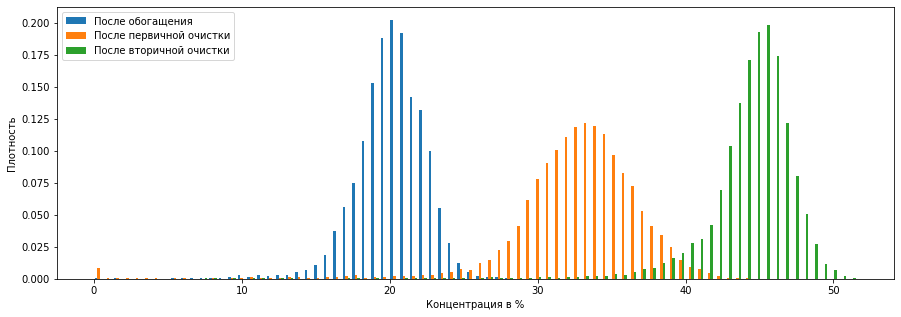

In [ ]:
concentration_change('rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au')

Видим, что после обогащения концентрация золота в руде относительно низкая, в районе 20%. После первичной очистки концентрация повышается в среднем на 15%, хоть и становится более "размазанной". Вторичная очистка повышает концентрацию золота ещё примерно на 10%, и основная масса руды получается с концентрацией золота в районе 45%

Изучим концентрацию серебра

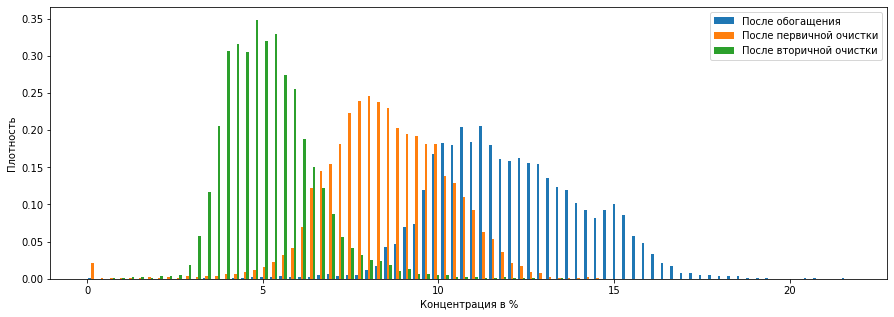

In [ ]:
concentration_change('rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag')

На графике видно, что на каждом этапе очистки концентрация серебра снижается. Причём с каждым этапом значения концентрации становятся более "кучными" 

Изучим концентрацию свинца

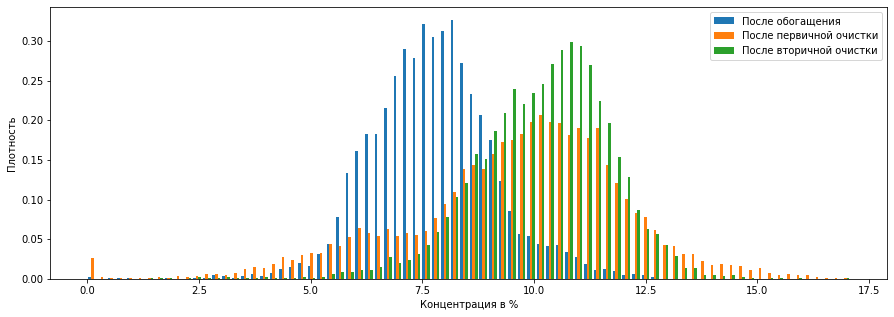

In [ ]:
concentration_change('rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb')

Судя по графику, очистка руды не затрагивает свинец, так как его концентрация увеличивается после поэтапной очистки. Это значит, что объём свинца не увеличивается, но и не уменьшается, а концентрация растёт за счёт снижения объёма других металлов в составе руды

### Сравнение распределения размеров гранул сырья

Сравним распределения размеров гранул сырья на обучающей и тестовой выборке в двух этапах: перед флотацией и перед первичной очисткой. Предварительно отсечем слишком крупные значения размеров для наглядности результата

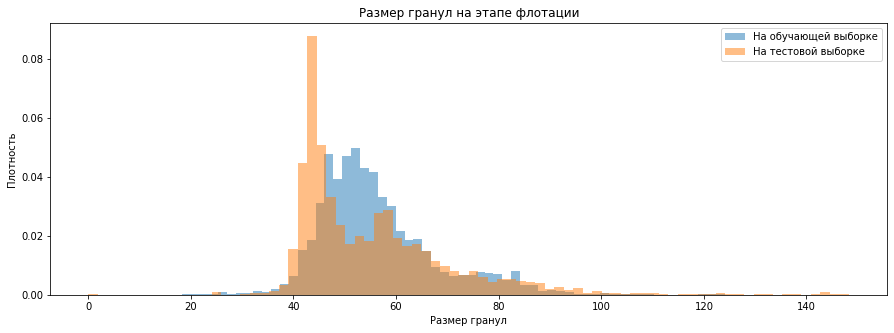

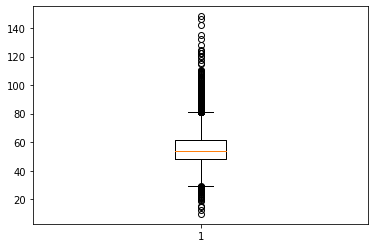

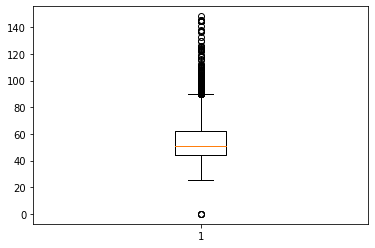

In [ ]:
train_array = np.array(data_train.loc[data_train['rougher.input.feed_size'] < 150, 'rougher.input.feed_size'])
test_array = np.array(data_test.loc[data_test['rougher.input.feed_size'] < 150, 'rougher.input.feed_size'])
plt.figure(figsize=(15, 5))
plt.hist(train_array, bins=80, density=True, alpha=0.5)
plt.hist(test_array, bins=80, density=True, alpha=0.5)
plt.legend(['На обучающей выборке', 'На тестовой выборке'])
plt.xlabel('Размер гранул')
plt.ylabel('Плотность')
plt.title('Размер гранул на этапе флотации')
plt.show()
plt.boxplot(train_array)
plt.show()
plt.boxplot(test_array)
plt.show()

На графиках видно, что исходное распределение размеров гранул до флотации различается, но не кардинально. Медианы примерно равны, так же, как и межквартильный размах

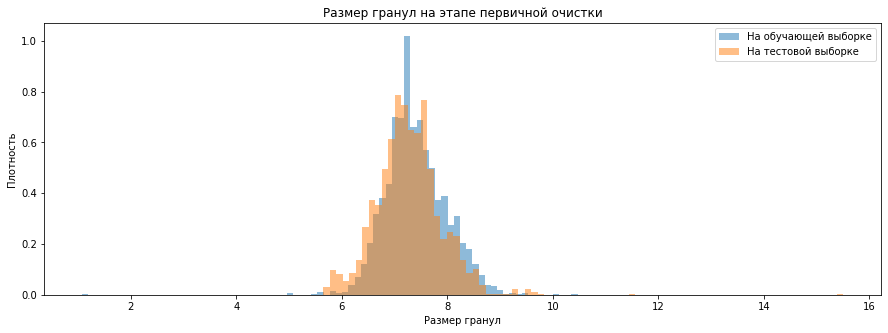

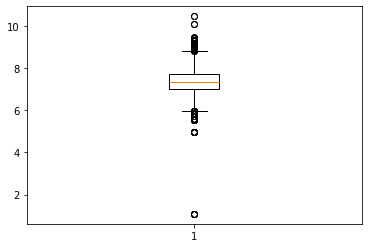

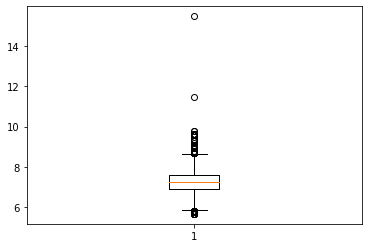

In [ ]:
train_array = np.array(data_train.loc[data_train['primary_cleaner.input.feed_size'] < 150, 'primary_cleaner.input.feed_size'])
test_array = np.array(data_test.loc[data_test['primary_cleaner.input.feed_size'] < 150, 'primary_cleaner.input.feed_size'])
plt.figure(figsize=(15, 5))
plt.hist(train_array, bins=80, density=True, alpha=0.5)
plt.hist(test_array, bins=80, density=True, alpha=0.5)
plt.legend(['На обучающей выборке', 'На тестовой выборке'])
plt.xlabel('Размер гранул')
plt.ylabel('Плотность')
plt.title('Размер гранул на этапе первичной очистки')
plt.show()
plt.boxplot(train_array)
plt.show()
plt.boxplot(test_array)
plt.show()

После флотации видим, что распределение становится очень похожим на двух выборках, не считая незначительного количества выбросов, а значит оценка модели должна быть верна

### Исследование суммарной концентрации всех веществ на разных стадиях

Исследуем суммарную концентрацию веществ на разных этапах очистки. Для этого напишем функцию

In [ ]:
def concentration_sum(ag, pb, sol, au):
    plt.figure(figsize=(15, 5))
    plt.hist(data_train[[ag, pb, sol, au]].sum(axis=1), bins=80, density=True)
    plt.xlabel('Концентрация в %')
    plt.ylabel('Плотность')
    plt.title('Суммарная концентрация веществ')
    plt.show()

Исходное сырьё

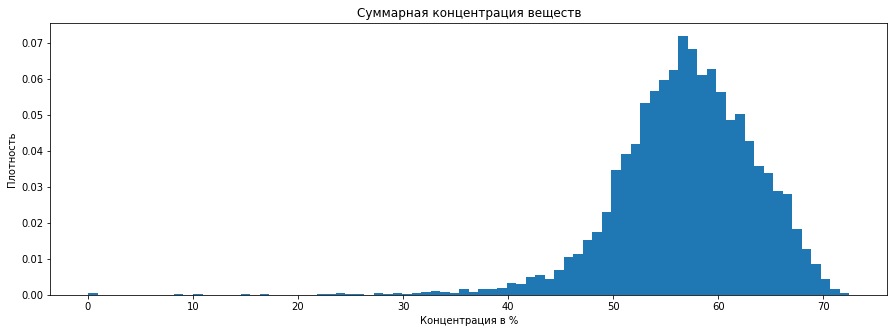

In [ ]:
concentration_sum('rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_sol', 'rougher.input.feed_au')

Видно, что в сырье большой "разброс" в концентрации веществ. В основном от 40 до 70%

В черновом концентрате

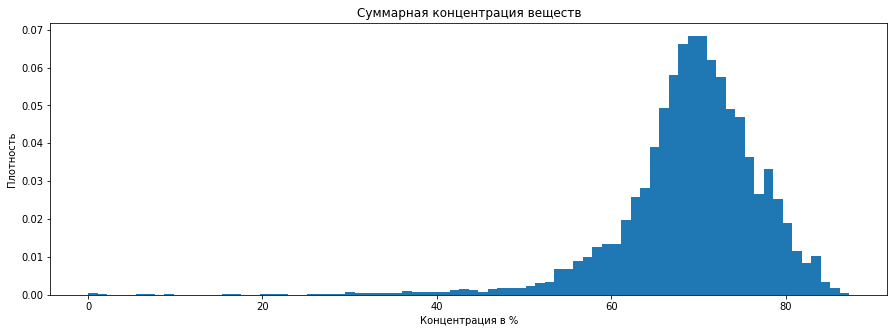

In [ ]:
concentration_sum('rougher.output.concentrate_ag', 'rougher.output.concentrate_pb',
                  'rougher.output.concentrate_sol', 'rougher.output.concentrate_au')

После обогащения распределение сместилось вправо. В основном концентрация веществ составляет от 50 до 80%, но "разброс" такой же, как и в исходном сырье

Финальный концентрат

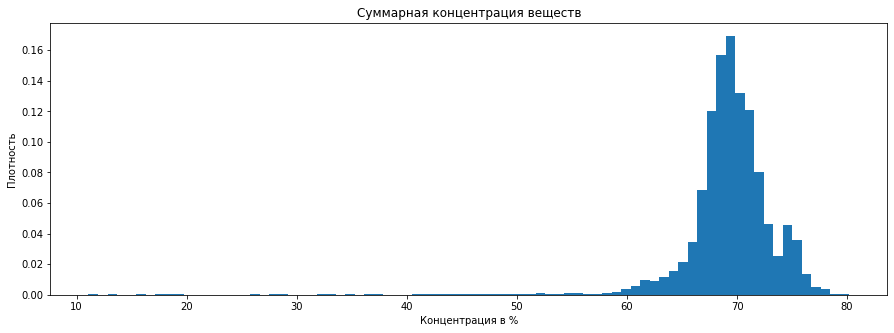

In [ ]:
concentration_sum('final.output.concentrate_ag', 'final.output.concentrate_pb',
                  'final.output.concentrate_sol', 'final.output.concentrate_au')

Два этапа очистки привели к тому, что распределние сузилось. В среднем суммарная концентрация веществ на финальной стадии составляет в районе 70%

## Модель

### Функция расчёта отклонения

Напишем функции для расчёта симметричного среднего абсолютного процентного отклонения и его итогового значения для двух целевых признаков

In [ ]:
def smape(target, predict):
    numerator = np.abs(target - predict)
    denominator = (np.abs(target) + np.abs(predict)) / 2
    return 1 / len(target) * np.sum(numerator / denominator) * 100

def total_smape(rougher_target, rougher_predict, final_target, final_predict):
    result = 0.25 * abs(smape(rougher_target, rougher_predict)) + 0.75 * abs(smape(final_target, final_predict))
    return result

Поместим функцию расчёта симметричного среднего абсолютного процентного отклонения в переменную для дальнейшего использования в качестве параметра кросс-валидации

In [ ]:
smape_score = make_scorer(smape, greater_is_better=False)

### Подготовка данных для обучения модели

Для того, чтобы утечка признака не произошла в самой обучающей выборке, нам нужно не учитывать столбцы, которые дают готовый результат технологического процесса. Это столбцы с типами параметров "output" и "calculation"

In [ ]:
data_train = data_train[['primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_b_air',
       'rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_c_air',
       'rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_d_air',
       'rougher.state.floatbank10_d_level', 'rougher.state.floatbank10_e_air',
       'rougher.state.floatbank10_e_level', 'rougher.state.floatbank10_f_air',
       'rougher.state.floatbank10_f_level',
       'secondary_cleaner.state.floatbank2_a_air',
       'secondary_cleaner.state.floatbank2_a_level',
       'secondary_cleaner.state.floatbank2_b_air',
       'secondary_cleaner.state.floatbank2_b_level',
       'secondary_cleaner.state.floatbank3_a_air',
       'secondary_cleaner.state.floatbank3_a_level',
       'secondary_cleaner.state.floatbank3_b_air',
       'secondary_cleaner.state.floatbank3_b_level',
       'secondary_cleaner.state.floatbank4_a_air',
       'secondary_cleaner.state.floatbank4_a_level',
       'secondary_cleaner.state.floatbank4_b_air',
       'secondary_cleaner.state.floatbank4_b_level',
       'secondary_cleaner.state.floatbank5_a_air',
       'secondary_cleaner.state.floatbank5_a_level',
       'secondary_cleaner.state.floatbank5_b_air',
       'secondary_cleaner.state.floatbank5_b_level',
       'secondary_cleaner.state.floatbank6_a_air',
       'secondary_cleaner.state.floatbank6_a_level', 'final.output.recovery',
       'rougher.output.recovery']]

Разделим обучающую выборку на 2 части. Так как нам необходимо предсказать 2 целевых признака в рамках одного последовательного технологического процесса, оставим для целевого признака "rougher.output.recovery" только ту часть данных, которая необходима для его расчёта, чтобы избежать утечки. Для второго целевого признака "final.output.recovery" используем все данные из подготовленной обучающей выборки, кроме первого целевого признака

In [ ]:
rougher_train_data = data_train[['rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_b_air',
       'rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_c_air',
       'rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_d_air',
       'rougher.state.floatbank10_d_level', 'rougher.state.floatbank10_e_air',
       'rougher.state.floatbank10_e_level', 'rougher.state.floatbank10_f_air',
       'rougher.state.floatbank10_f_level', 'rougher.output.recovery']]

features_rougher_train = rougher_train_data.drop(['rougher.output.recovery'], axis=1)
target_rougher_train = rougher_train_data['rougher.output.recovery']

In [ ]:
final_train_data = data_train.drop(['rougher.output.recovery'], axis=1)

features_final_train = final_train_data.drop(['final.output.recovery'], axis=1)
target_final_train = final_train_data['final.output.recovery']

Сделаем тоже самое с тестовой выборкой, предварительно добавив в неё оба целевых признака из общей выборки и удалив пропуски

In [ ]:
data_test = data_test.merge(data_full[['final.output.recovery', 'rougher.output.recovery']], on='date')
data_test = data_test.dropna()

In [ ]:
rougher_test_data = data_test[['rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_b_air',
       'rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_c_air',
       'rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_d_air',
       'rougher.state.floatbank10_d_level', 'rougher.state.floatbank10_e_air',
       'rougher.state.floatbank10_e_level', 'rougher.state.floatbank10_f_air',
       'rougher.state.floatbank10_f_level', 'rougher.output.recovery']]

features_rougher_test = rougher_test_data.drop(['rougher.output.recovery'], axis=1)
target_rougher_test = rougher_test_data['rougher.output.recovery']

In [ ]:
final_test_data = data_test.drop(['rougher.output.recovery'], axis=1)

features_final_test = final_test_data.drop(['final.output.recovery'], axis=1)
target_final_test = final_test_data['final.output.recovery']

### Обучаем модели

#### Решающее дерево

Построим модель решающего дерева с кросс-валидацией

In [ ]:
params_dt = {'max_depth': range(1, 16)}
cv_dt = RandomizedSearchCV(DecisionTreeRegressor(random_state=12345), params_dt, scoring=smape_score)

Применяем к первой части обучающих данных 

In [ ]:
rougher_model = cv_dt.fit(features_rougher_train, target_rougher_train)
print('Лучшие параметры решающего дерева, {}'.format(rougher_model.best_params_))
print('Лучшая оценка sMAPE решающего дерева, {}'.format(abs(rougher_model.best_score_)))

Лучшие параметры решающего дерева, {'max_depth': 2}
Лучшая оценка sMAPE решающего дерева, 6.321272419657495


Ко второй части

In [ ]:
final_model = cv_dt.fit(features_final_train, target_final_train)
print('Лучшие параметры решающего дерева, {}'.format(final_model.best_params_))
print('Лучшая оценка sMAPE решающего дерева, {}'.format(abs(final_model.best_score_)))

Лучшие параметры решающего дерева, {'max_depth': 1}
Лучшая оценка sMAPE решающего дерева, 8.211123544466634


#### Случайный лес

Построим модель случайного леса с кросс-валидацией

In [ ]:
params_rf = {'max_depth': range(1, 16),
            'n_estimators': range(10, 101, 10)}
cv_rf = RandomizedSearchCV(RandomForestRegressor(random_state=12345), params_rf, scoring=smape_score)

Применяем к первой части обучающих данных

In [ ]:
rougher_model = cv_rf.fit(features_rougher_train, target_rougher_train)
print('Лучшие параметры случайного леса, {}'.format(rougher_model.best_params_))
print('Лучшая оценка sMAPE случайного леса, {}'.format(abs(rougher_model.best_score_)))

Лучшие параметры случайного леса, {'n_estimators': 70, 'max_depth': 5}
Лучшая оценка sMAPE случайного леса, 5.918575412442467


Ко второй части

In [ ]:
final_model = cv_rf.fit(features_final_train, target_final_train)
print('Лучшие параметры случайного леса, {}'.format(final_model.best_params_))
print('Лучшая оценка sMAPE случайного леса, {}'.format(abs(final_model.best_score_)))

Лучшие параметры случайного леса, {'n_estimators': 80, 'max_depth': 1}
Лучшая оценка sMAPE случайного леса, 8.155008719434779


#### Линейная регрессия

Построим модель линейной регрессии с кросс-валидацией

In [ ]:
cv_lr = GridSearchCV(LinearRegression(), param_grid={}, scoring=smape_score)

Применим к первой части обучающих данных

In [ ]:
rougher_model = cv_lr.fit(features_rougher_train, target_rougher_train)
print('Оценка sMAPE линейной регрессии, {}'.format(abs(rougher_model.best_score_)))

Оценка sMAPE линейной регрессии, 6.339313090680679


Ко второй части

In [ ]:
final_model = cv_lr.fit(features_final_train, target_final_train)
print('Оценка sMAPE линейной регрессии, {}'.format(abs(final_model.best_score_)))

Оценка sMAPE линейной регрессии, 9.018601124709182


#### CatBoostRegressor

In [ ]:
params_catboost = {'iterations': range(10, 101, 10),
                  'depth': range(1, 5)}

cv_catboost = RandomizedSearchCV(CatBoostRegressor(random_state=12345, verbose=False), params_catboost, scoring=smape_score)

Применяем к первой части обучающих данных

In [ ]:
rougher_model = cv_catboost.fit(features_rougher_train, target_rougher_train)
print('Лучшие параметры catboost, {}'.format(rougher_model.best_params_))
print('Лучшая оценка sMAPE catboost, {}'.format(abs(rougher_model.best_score_)))

Лучшие параметры catboost, {'iterations': 20, 'depth': 1}
Лучшая оценка sMAPE catboost, 6.021461761671516


Ко второй части

In [ ]:
final_model = cv_catboost.fit(features_final_train, target_final_train)
print('Лучшие параметры catboost, {}'.format(final_model.best_params_))
print('Лучшая оценка sMAPE catboost, {}'.format(abs(final_model.best_score_)))

Лучшие параметры catboost, {'iterations': 50, 'depth': 1}
Лучшая оценка sMAPE catboost, 8.578312581341056


#### Lasso

In [ ]:
params_lasso = {'alpha': np.arange(0.1, 1.1, 0.1)}

cv_lasso = RandomizedSearchCV(Lasso(random_state=12345), params_lasso, scoring=smape_score)

Применим к первой части обучающих данных

In [ ]:
rougher_model = cv_lasso.fit(features_rougher_train, target_rougher_train)
print('Лучшие параметры Lasso, {}'.format(rougher_model.best_params_))
print('Лучшая оценка sMAPE Lasso, {}'.format(abs(rougher_model.best_score_)))

Лучшие параметры Lasso, {'alpha': 0.1}
Лучшая оценка sMAPE Lasso, 6.5266405328736905


Ко второй части

In [ ]:
final_model = cv_lasso.fit(features_final_train, target_final_train)
print('Лучшие параметры Lasso, {}'.format(final_model.best_params_))
print('Лучшая оценка sMAPE Lasso, {}'.format(abs(final_model.best_score_)))

Лучшие параметры Lasso, {'alpha': 0.2}
Лучшая оценка sMAPE Lasso, 8.834803647900836


#### Проверка на dummy модели

In [ ]:
cv_dummy = GridSearchCV(DummyRegressor(), param_grid={}, scoring=smape_score)

rougher_dummy_model = cv_dummy.fit(features_rougher_train, target_rougher_train)
print('Оценка sMAPE dummy модели к 1 части данных, {}'.format(abs(rougher_dummy_model.best_score_)))

final_dummy_model = cv_dummy.fit(features_final_train, target_final_train)
print('Оценка sMAPE dummy модели ко 2 части данных, {}'.format(abs(final_dummy_model.best_score_)))

Оценка sMAPE dummy модели к 1 части данных, 7.597367299040096
Оценка sMAPE dummy модели ко 2 части данных, 9.461677448099543


Таким образом, лучшей моделью с самым низким отклонением является случайный лес. Проверим её на тестовой выборке

### Проверка модели на тестовой выборке

Применим лучшую модель (линейная регрессия) к первой части тестовых данных

In [ ]:
model = RandomForestRegressor(random_state=12345, n_estimators=70, max_depth=5)
rougher_best_model = model.fit(features_rougher_train, target_rougher_train)
print('Оценка sMAPE случайного леса на тестовой выборке:', 
      abs(smape(target_rougher_test, rougher_best_model.predict(features_rougher_test))))

Оценка sMAPE случайного леса на тестовой выборке: 7.94983665497742


Ко второй части

In [ ]:
model = RandomForestRegressor(random_state=12345, n_estimators=80, max_depth=1)
final_best_model = model.fit(features_final_train, target_final_train)
print('Оценка sMAPE случайного леса на тестовой выборке:', 
      abs(smape(target_final_test, final_best_model.predict(features_final_test))))

Оценка sMAPE случайного леса на тестовой выборке: 9.078648543380561


Определим итоговый sMAPE по двум целевым показателям для лучшей модели на тестовых выборках

In [ ]:
total_smape(target_rougher_test, rougher_best_model.predict(features_rougher_test), 
            target_final_test, final_best_model.predict(features_final_test))

8.796445571279776

Таким образом, итоговое симметричное среднее абсолютное процентное отклонение по двум целевым признакам составляет около 8.8%

**Вывод**

В ходе исследования мы подготовили данные, проверили правильность расчёта эффективности обогащения руды, проанализировали концентрацию веществ на разных этапах очистки и построили несколько моделей машинного обучения для того, чтобы выявить, какая из них покажет самое низкое значение метрики относительного отклонения эффективности обогащения руды, сложенной из двух целевых признаков. Также мы сравнили модели с константной моделью, чтобы иметь верное представление об эффективности наших моделей. Определив, что лучшей моделью является случайный лес, мы проверили её на тестовой выборке, получили значения 7.95% и 9.08% для первого и второго целевого признака соответственно. Затем получили итоговую метрику со значение 8.8%, рассчитав по формуле обе тестовые выборки